# Download Data and Pretrained Word Embeddings 

In [0]:
!mkdir -p data/spam_data

In [0]:
## Get dataset and save in local folder ##

!wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2

!tar xvjf 20030228_easy_ham_2.tar.bz2
!tar xvjf 20030228_easy_ham.tar.bz2
!tar xvjf 20030228_hard_ham.tar.bz2    
!tar xvjf 20030228_spam.tar.bz2
!tar xvjf 20050311_spam_2.tar.bz2

!mv easy_ham data/spam_data  
!mv easy_ham_2 data/spam_data
!mv hard_ham data/spam_data
!mv spam data/spam_data
!mv spam_2 data/spam_data

In [0]:
## Download and unzip the GloVe embedding ##

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

!python -m gensim.scripts.glove2word2vec -i glove.6B.300d.txt -o glove.6B.300d.word2vec.txt

In [0]:
## Import NLTK packages ##

import nltk
nltk.download('punkt')
nltk.download('wordnet')

# Start Coding

In [0]:
import os
import glob
import numpy as np
import email

In [0]:
path = 'data/spam_data/'

In [0]:
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [0]:
def get_email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

# Split data into train/test

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
ham_path = [
    easy_ham_paths,
    easy_ham_2_paths,
    hard_ham_paths
]

spam_path = [
    spam_paths,
    spam_2_paths
]

In [0]:
ham_sample = np.array([train_test_split(o) for o in ham_path])

In [0]:
ham_train = np.array([])
ham_test = np.array([])
for o in ham_sample:
    ham_train = np.concatenate((ham_train,o[0]),axis=0)
    ham_test = np.concatenate((ham_test,o[1]),axis=0)

In [29]:
ham_train.shape, ham_test.shape

((3113,), (1040,))

In [0]:
spam_sample = np.array([train_test_split(o) for o in spam_path])

In [0]:
spam_train = np.array([])
spam_test = np.array([])
for o in spam_sample:
    spam_train = np.concatenate((spam_train,o[0]),axis=0)
    spam_test = np.concatenate((spam_test,o[1]),axis=0)

In [32]:
spam_train.shape, spam_test.shape

((1422,), (476,))

In [0]:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

In [0]:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [0]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

In [0]:
x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]

In [0]:
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [0]:
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

In [0]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [0]:
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

# Preprocessing

## Process sentence

In [0]:
import re
import string
from nltk.tokenize import word_tokenize

In [0]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [0]:
def to_lower(word):
    result = word.lower()
    return result

In [0]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [0]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [0]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [0]:
def replace_newline(word):
    return word.replace('\n','')

In [0]:
def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [0]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

## Process word by word

In [50]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [0]:
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [0]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [0]:
def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

In [0]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

In [0]:
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words,word_stemmer,word_lemmatizer]
    for o in cleaning_utils:
        words = o(words)
    return words

In [0]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [58]:
from gensim.models import KeyedVectors

w2v = KeyedVectors.load_word2vec_format('glove.6B.300d.word2vec.txt',binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Data Visualization

In [0]:
# This function is needed to include in the cell to show the plotly graph 
# in colab

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [115]:
from collections import defaultdict
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [0]:
x_train_join = [" ".join(o) for o in x_train]
x_test_join = [" ".join(o) for o in x_test]

In [0]:
spam_train_index = [i for i,o in enumerate(y_train) if o == 1]
non_spam_train_index = [i for i,o in enumerate(y_train) if o == 0]

spam_email = np.array(x_train_join)[spam_train_index]
non_spam_email = np.array(x_train_join)[non_spam_train_index]

In [0]:
## N-gram bar chart visualization ##

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace


In [0]:
def visualize_in_bar_chart(word_count=1):
    ## Get the bar chart from non-spam email ##
    freq_dict = defaultdict(int)
    for sent in non_spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace0 = horizontal_bar_chart(fd_sorted.head(20), 'orange')

    ## Get the bar chart from spam email ##
    freq_dict = defaultdict(int)
    for sent in spam_email:
        for word in generate_ngrams(sent,word_count):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace1 = horizontal_bar_chart(fd_sorted.head(20), 'orange')

    # Creating two subplots
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of non spam email", 
                                              "Frequent words of spam email"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=600, width=800, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')

In [0]:
configure_plotly_browser_state()
visualize_in_bar_chart(2)

In [0]:
## Wordcloud Visualization ##

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()


#plot_wordcloud(spam_email,title = 'Spam Email')
#plot_wordcloud(non_spam_email,title="Non Spam Email")

# TF-IDF based Embedding With  Naive-Bayes and SVM Classifiers

In [0]:
## Compute TF-IDF features using sklearn ##

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit_transform(x_train_join)
x_train_features = vectorizer.transform(x_train_join)
x_test_features = vectorizer.transform(x_test_join)

In [62]:
## Train a Naive Bayes Classifier ##

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

clf = GaussianNB()

clf.fit(x_train_features.toarray(),y_train)

clf.score(x_test_features.toarray(),y_test)

clf.score(x_train_features.toarray(),y_train)

0.9963302752293578

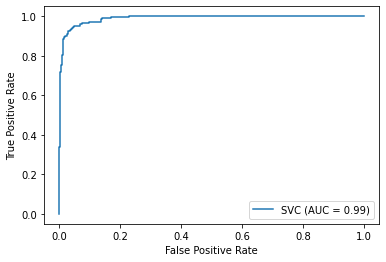

In [66]:
## Train an SVM based Classifier ##

from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

clf = SVC(gamma='auto')

clf.fit(x_train_features.toarray(),y_train)

clf.score(x_test_features.toarray(),y_test)

clf.score(x_train_features.toarray(),y_train)

clf_disp = plot_roc_curve(clf, x_test_features.toarray(),y_test)

# GloVe-based Embeding and Training using Bidirectional LSTM

In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [0]:
maxlen = 2000
max_features = 50000

In [0]:
EMBEDDING_FILE = 'glove.6B.300d.txt'
tokenizer = Tokenizer(num_words=max_features)

In [0]:
tokenizer.fit_on_texts(x_train)

In [0]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

x_train_features = pad_sequences(x_train_features,maxlen=maxlen)
x_test_features = pad_sequences(x_test_features,maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, activation='tanh',return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [0]:
model.layers[1].trainable = False

In [0]:
history = model.fit(x_train_features,y_train, batch_size=512, epochs=20, 
          validation_data=(x_test_features, y_test))

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Custom Embedding and training using Bidirectional LSTM

In [0]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [0]:
tokenizer = Tokenizer(num_words=max_feature)

In [0]:
tokenizer.fit_on_texts(x_train)

In [0]:
x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

In [0]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)

In [0]:
embed_size = 100

inp = Input(shape=(max_len,))
x = Embedding(max_feature, embed_size)(inp)
x = Bidirectional(LSTM(64, activation = 'tanh', return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

In [0]:
history = model.fit(x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Error Analysis

In [0]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

In [0]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [0]:
confusion_matrix(y_test,y_predict)

In [0]:
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

In [0]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

In [0]:
f1_score(y_test,y_predict)

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test,y_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot normalized confusion matrix

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non Spam','Spam'], normalize=False,
                      title='Confusion matrix')